## ĐỌC DỮ LIỆU VÀ KHÁM PHÁ DỮ LIỆU

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data/raw/weather_raw.csv")

### 1. Tổng quan dữ liệu

In [2]:
# số dòng/cột
print("Số dòng:", df.shape[0])
print("Số cột:", df.shape[1])

Số dòng: 300958
Số cột: 10


In [3]:
# xem qua thông tin của 5 dòng đầu tiên
df.head(5)

,latitude,longitude,datetime,temperature (C degree),humidity (%),precipitation (mm),windspeed (km/h),winddirection (degrees),pressure (hPa),dewpoint (C degree)
0,16.58,107.61,2021-01-01 00:00:00,15.6,98.0,NaN,3.6,320.0,1022.0,15.3
1,16.58,107.61,2021-01-01 01:00:00,16.0,100.0,NaN,13.0,260.0,1023.0,16.0
2,16.58,107.61,2021-01-01 02:00:00,17.0,94.0,NaN,9.4,250.0,1024.0,16.0
3,16.58,107.61,2021-01-01 03:00:00,16.6,96.0,NaN,7.2,340.0,1023.5,16.0
4,16.58,107.61,2021-01-01 04:00:00,17.0,94.0,NaN,7.6,260.0,1024.0,16.0


In [4]:
# xem các cột có kiểu dữ liệu gì
cols = df.columns
print(df.dtypes)

latitude                   float64
longitude                  float64
datetime                    object
temperature (C degree)     float64
humidity (%)               float64
precipitation (mm)         float64
windspeed (km/h)           float64
winddirection (degrees)    float64
pressure (hPa)             float64
dewpoint (C degree)        float64
dtype: object


Hiện tại ngoại trừ datetime các cột còn lại có giá trị hợp lý, không có điểm bất thường. Tiến hành chuẩn hóa đưa datetime ở kiểu dữ liệu object thành datetime

In [5]:
# định dạng datetime từ kiểu object thành kiểu datetime
df['datetime'] = pd.to_datetime(df['datetime'])
print(df['datetime'].dtypes)

datetime64[ns]


### 2. Kiểm tra dữ liệu thiếu

In [6]:
missing_table = pd.DataFrame({
    "Số ô thiếu": df.isnull().sum(),
    "Tỷ lệ thiếu %": df.isnull().mean() * 100
})

print(missing_table)

                         Số ô thiếu  Tỷ lệ thiếu %
latitude                          0       0.000000
longitude                         0       0.000000
datetime                          0       0.000000
temperature (C degree)           35       0.011630
humidity (%)                     35       0.011630
precipitation (mm)             3283       1.090850
windspeed (km/h)                 56       0.018607
winddirection (degrees)       14126       4.693678
pressure (hPa)                 7077       2.351491
dewpoint (C degree)              63       0.020933


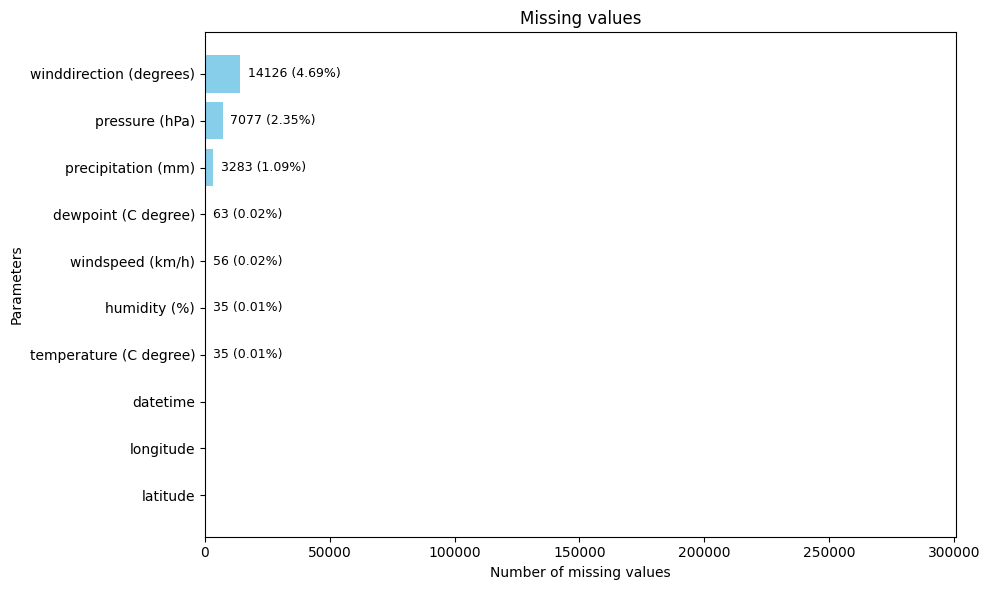

In [7]:
missing_table_sorted = missing_table.sort_values("Số ô thiếu")

plt.figure(figsize=(10, 6))
bars = plt.barh(missing_table_sorted.index, missing_table_sorted["Số ô thiếu"], color='skyblue')

total_rows = len(df)
plt.xlim(0, total_rows) 

for bar, missing in zip(bars, missing_table_sorted["Số ô thiếu"]):
    percent = (missing / total_rows) * 100
    
    if missing > 0:
        label = f'{missing} ({percent:.2f}%)'
        plt.text(bar.get_width() + (total_rows * 0.01),
                 bar.get_y() + bar.get_height()/2, 
                 label, 
                 va='center', 
                 fontsize=9)

plt.xlabel("Number of missing values")
plt.ylabel("Parameters")
plt.title(f"Missing values")
plt.tight_layout()
plt.show()

In [8]:
# kiểm tra nội dung có bị trùng lặp hay không 
print("Số dòng bị trùng:", df.duplicated().sum())

Số dòng bị trùng: 0


### 3. Thống kê mô tả

Dựa trên lý thuyết ta có các ngưỡng thường xuất hiện của các yếu tố thời tiết ở Huế như sau:
* Temperature (°C) : 10-40
* Humidity (%) : 40-100
* Wind speed (km/h) : 0-120
* Precipitation (mm) : 0-300
* Pressure : 980-1030
* Dew point (°C) : 5-30

In [9]:
# tiến hành kiểm tra các khoảng giá trị của các yếu tố thời tiết có hợp lí chưa
cols_to_drop = ["latitude", "longitude"]

desc_table = pd.DataFrame({
    "Min": df.drop(columns=cols_to_drop).min(numeric_only=True),
    "Max": df.drop(columns=cols_to_drop).max(numeric_only=True),
    "Mean": df.drop(columns=cols_to_drop).mean(numeric_only=True),
    "Std": df.drop(columns=cols_to_drop).std(numeric_only=True)
})

print(desc_table)


                           Min     Max         Mean        Std
temperature (C degree)    10.4    42.0    26.069122   4.804753
humidity (%)               0.0   100.0    81.971877  14.144686
precipitation (mm)         0.0    53.7     0.344546   1.291834
windspeed (km/h)           0.0   245.0     8.131457   5.862435
winddirection (degrees)    0.0   360.0   195.973814  97.671591
pressure (hPa)           991.0  1028.2  1010.541205   5.751789
dewpoint (C degree)        2.2    28.6    22.410336   2.936650


So sánh dữ liệu từ bộ data so với range ta thấy:
- Huminity 3% rất phi thực tế ở Huế
- Wind speed 245 km/h là cực kỳ bất thường ở Huế (thường là siêu bão cấp 16-17) mà Huế chưa từng có gió có cường độ như thế.
- Temparature 42 độ C là rất cao, sát ngưỡng bất thường => Huế rất hiếm khi vượt 40 độ C 

Ngoài ra các giá trị còn lại khá hợp lý, không có điểm bất thường nào khác cần lưu ý 

=> Tiến hành phân tích sâu các yếu tố được cho là bất thường đã đề cập phía trên

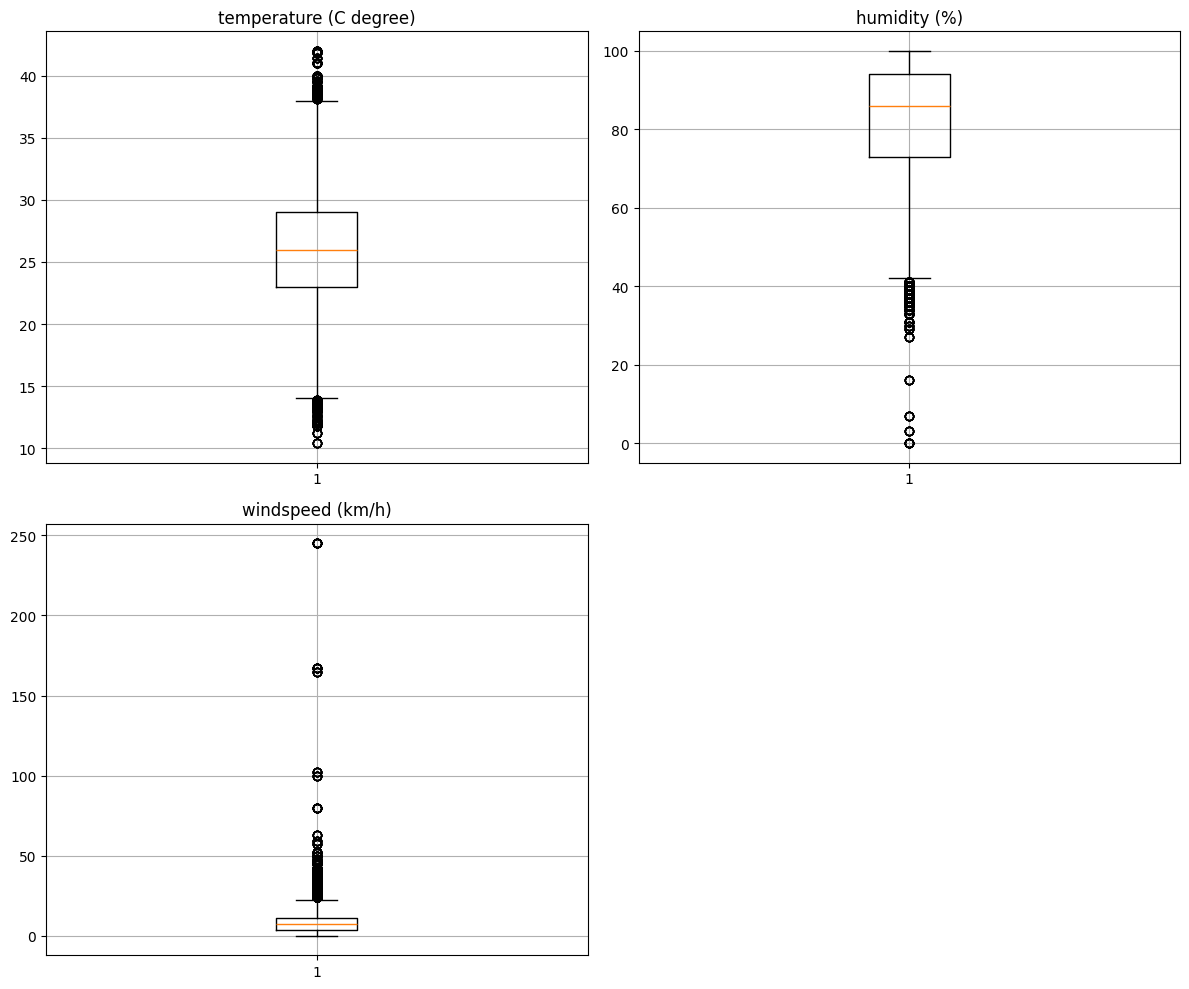

In [10]:
cols = [
    "temperature (C degree)",
    "humidity (%)",
    "windspeed (km/h)"
]

n_cols = 2                     
n_rows = (len(cols) + 1) // 2

plt.figure(figsize=(12, 10))

for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(df[col].dropna())
    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
rows_humidity_3 = df[df["humidity (%)"] <= 3.0]
print("Số dòng có humidity = 3%:", len(rows_humidity_3))

print(rows_humidity_3)


Số dòng có humidity = 3%: 21
        latitude  longitude            datetime  temperature (C degree)  \
20029      16.58     107.61 2023-04-16 19:00:00                     NaN   
20797      16.58     107.61 2023-05-18 19:00:00                     NaN   
41360      16.58     107.61 2025-09-22 18:00:00                     NaN   
63023      16.52     107.59 2023-04-16 19:00:00                     NaN   
63791      16.52     107.59 2023-05-18 19:00:00                     NaN   
84354      16.52     107.59 2025-09-22 18:00:00                     NaN   
106017     16.47     107.62 2023-04-16 19:00:00                     NaN   
106785     16.47     107.62 2023-05-18 19:00:00                     NaN   
127348     16.47     107.62 2025-09-22 18:00:00                     NaN   
149011     16.43     107.58 2023-04-16 19:00:00                     NaN   
149779     16.43     107.58 2023-05-18 19:00:00                     NaN   
170342     16.43     107.58 2025-09-22 18:00:00                     NaN

Sau khi liệt kê các dòng dữ liệu liên quan đến sự bất thường của độ ẩm (<=3%) thì ta nhận thấy các thông số về nhiệt độ và điểm sương đều trống. Cho thấy các thông tin trong dòng dữ liệu này không đủ để phục vụ việc phân tích sau này 

=> Tiến hành loại bỏ các cột này

In [12]:
df.drop(df[df["humidity (%)"] <= 3].index, inplace=True)
print("Số dòng còn lại:", len(df))
print("Còn humidity <= 3% không?", (df["humidity (%)"] <= 3).any())

Số dòng còn lại: 300937
Còn humidity <= 3% không? False


In [13]:
# số dòng chứa dữ liệu bất thường của tốc độ gió
rows_windspeed = df[df["windspeed (km/h)"] > 120]
print("Số dòng có windspeed >120:", len(rows_windspeed))

print(rows_windspeed)

Số dòng có windspeed >120: 35
        latitude  longitude            datetime  temperature (C degree)  \
12311      16.58     107.61 2022-05-29 08:00:00                    33.0   
14974      16.58     107.61 2022-09-17 07:00:00                    34.0   
42060      16.58     107.61 2025-10-22 02:00:00                    23.0   
42221      16.58     107.61 2025-10-28 19:00:00                    25.0   
42727      16.58     107.61 2025-11-18 22:00:00                    21.0   
55305      16.52     107.59 2022-05-29 08:00:00                    33.0   
57968      16.52     107.59 2022-09-17 07:00:00                    34.0   
85054      16.52     107.59 2025-10-22 02:00:00                    23.0   
85215      16.52     107.59 2025-10-28 19:00:00                    25.0   
85721      16.52     107.59 2025-11-18 22:00:00                    21.0   
98299      16.47     107.62 2022-05-29 08:00:00                    33.0   
100962     16.47     107.62 2022-09-17 07:00:00                    34.

In [14]:
rows_temp = df[df["temperature (C degree)"] >40]
print("Số dòng có temperature:", len(rows_temp))

print(rows_temp)

Số dòng có temperature: 77
        latitude  longitude            datetime  temperature (C degree)  \
29031      16.58     107.61 2024-04-26 04:00:00                    41.0   
29032      16.58     107.61 2024-04-26 05:00:00                    41.0   
29056      16.58     107.61 2024-04-27 05:00:00                    41.0   
29057      16.58     107.61 2024-04-27 06:00:00                    41.4   
29079      16.58     107.61 2024-04-28 04:00:00                    41.0   
...          ...        ...                 ...                     ...   
287091     16.44     107.65 2024-04-30 04:00:00                    41.0   
287092     16.44     107.65 2024-04-30 05:00:00                    42.0   
287093     16.44     107.65 2024-04-30 06:00:00                    41.8   
287116     16.44     107.65 2024-05-01 05:00:00                    42.0   
287117     16.44     107.65 2024-05-01 06:00:00                    42.0   

        humidity (%)  precipitation (mm)  windspeed (km/h)  \
29031     

## TIỀN XỬ LÝ DỮ LIỆU


In [15]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### 1. Điền dữ liệu thiếu

In [16]:
# nội suy tuyến tính cho các biến liên tục
df["temperature (C degree)"] = df["temperature (C degree)"].interpolate()
df["humidity (%)"] = df["humidity (%)"].interpolate()
df["windspeed (km/h)"] = df["windspeed (km/h)"].interpolate()
df["pressure (hPa)"] = df["pressure (hPa)"].interpolate()
df["dewpoint (C degree)"] = df["dewpoint (C degree)"].interpolate()

# hướng gió: đổi sang vector để nội suy
theta = np.deg2rad(df["winddirection (degrees)"])
u = np.cos(theta)
v = np.sin(theta)
u = pd.Series(u).interpolate()
v = pd.Series(v).interpolate()
df["winddirection (degrees)"] = (np.rad2deg(np.arctan2(v, u)) + 360) % 360

In [17]:
# fill missing precipitation bằng KNN Imputer
df = df.sort_values(by=['latitude', 'longitude', 'datetime'])

def fill_rain_knn(group):
    feature_cols = ['temperature (C degree)', 'humidity (%)', 'pressure (hPa)', 'dewpoint (C degree)', 'precipitation (mm)']
    
    data = group[feature_cols].copy()
    
    # scale data về 0-1 vì KNN tính khoảng cách, số to (áp suất 1000) sẽ lấn át giá trị bé
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    imputer = KNNImputer(n_neighbors=5, weights='distance') # k=5
    data_filled = imputer.fit_transform(data_scaled) # fill dữ liệu
    
    # đảo ngược scale, trả lại giá trị gốc 
    data_final = scaler.inverse_transform(data_filled)
    group['precipitation (mm)'] = data_final[:, -1] # gán vào df     
    
    return group

# fill lượng mưa theo từng lat/long
df_filled = df.groupby(['latitude', 'longitude'], group_keys=False).apply(fill_rain_knn)

# tránh giá trị âm
df_filled['precipitation (mm)'] = df_filled['precipitation (mm)'].clip(lower=0)

print("Số lượng missing sau khi nội suy:")
print(df_filled.isnull().sum())

Số lượng missing sau khi nội suy:
latitude                   0
longitude                  0
datetime                   0
temperature (C degree)     0
humidity (%)               0
precipitation (mm)         0
windspeed (km/h)           0
winddirection (degrees)    0
pressure (hPa)             0
dewpoint (C degree)        0
dtype: int64


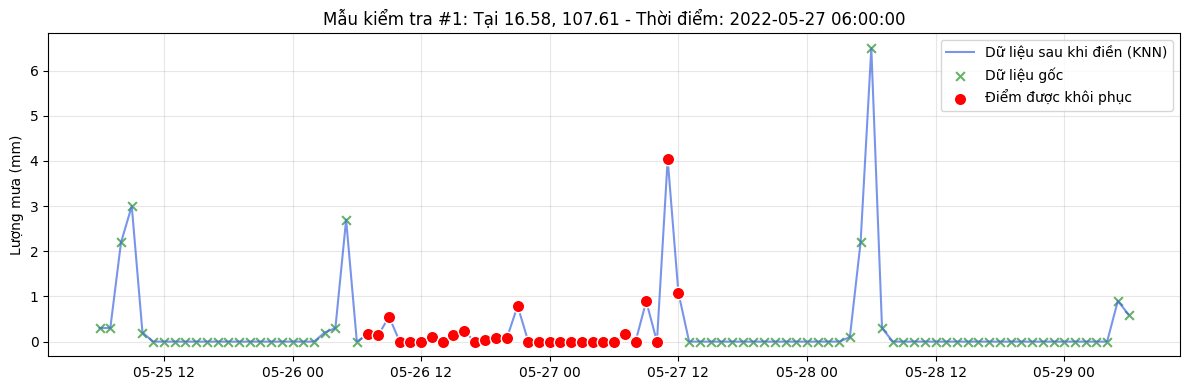

Mẫu #1 (2022-05-27 06:00:00): Giá trị gốc=NaN -> KNN điền=0.00 mm
------------------------------------------------------------


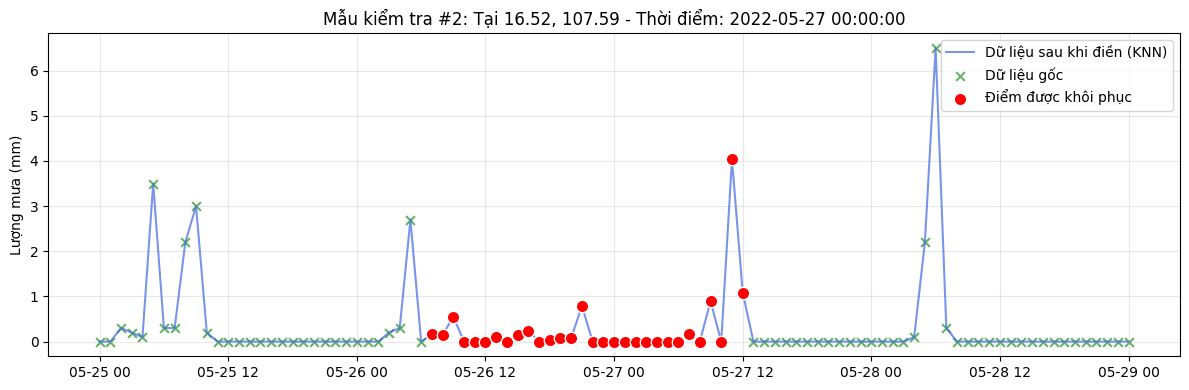

Mẫu #2 (2022-05-27 00:00:00): Giá trị gốc=NaN -> KNN điền=0.00 mm
------------------------------------------------------------


In [18]:
missing_indices = df[df['precipitation (mm)'].isnull()].index

if len(missing_indices) > 0:
    sample_indices = np.random.choice(missing_indices, 2, replace=False)
    
    for i, idx in enumerate(sample_indices):
        row = df.loc[idx]
        target_lat = row['latitude']
        target_long = row['longitude']
        center_time = row['datetime']
        
        # khung thời gian +/- 2 ngày quanh điểm thiếu 
        start_time = center_time - pd.Timedelta(days=2)
        end_time = center_time + pd.Timedelta(days=2)
        
        # lọc dữ liệu tại trạm đó, trong khoảng thời gian đó
        mask = (df_filled['latitude'] == target_lat) & \
               (df_filled['longitude'] == target_long) & \
               (df_filled['datetime'] >= start_time) & \
               (df_filled['datetime'] <= end_time)
        
        subset_filled = df_filled[mask]
        subset_raw = df[mask]
        
        plt.figure(figsize=(12, 4))
        
        # dữ liệu sau khi điền (đường line liên tục)
        plt.plot(subset_filled['datetime'], subset_filled['precipitation (mm)'], 
                 label='Dữ liệu sau khi điền (KNN)', color='royalblue', linewidth=1.5, alpha=0.7)
        
        # dữ liệu gốc
        plt.scatter(subset_raw['datetime'], subset_raw['precipitation (mm)'], 
                    label='Dữ liệu gốc', color='green', marker='x', s=40, alpha=0.6)
        
        # điểm vừa được khôi phục
        imputed_points = subset_filled.loc[subset_raw[subset_raw['precipitation (mm)'].isnull()].index]
        plt.scatter(imputed_points['datetime'], imputed_points['precipitation (mm)'], 
                    label='Điểm được khôi phục', color='red', s=80, zorder=5, edgecolors='white')
        
        plt.title(f'Mẫu kiểm tra #{i+1}: Tại {target_lat}, {target_long} - Thời điểm: {center_time}')
        plt.ylabel('Lượng mưa (mm)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        filled_val = df_filled.loc[idx, 'precipitation (mm)']
        print(f"Mẫu #{i+1} ({center_time}): Giá trị gốc=NaN -> KNN điền={filled_val:.2f} mm")
        print("-" * 60)

else:
    print("Không tìm thấy dữ liệu thiếu để kiểm tra.")

Dựa vào 2 mẫu minh hoạ ta thấy KNN điền dữ liệu lượng mưa bị thiếu tương đối hợp lý, chấp nhận được. Nhóm tạm dùng cách điền dữ liệu này.

### 2. Trích xuất đặc trưng

In [19]:
# tháng và giờ
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

# mùa khô và mùa mưa
df['season'] = df['month'].apply(lambda x: 'Rainy' if 5 <= x <= 11 else 'Dry')

# label ngày/đêm
df['day_night'] = df['hour'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

# đổi lat-long thành id khu vực
df['location_id'] = df.groupby(['latitude', 'longitude']).ngroup() + 1
df = df.drop(columns=['latitude', 'longitude'])

df.sample(5)

,datetime,temperature (C degree),humidity (%),precipitation (mm),windspeed (km/h),winddirection (degrees),pressure (hPa),dewpoint (C degree),month,hour,season,day_night,location_id
191394,2023-03-22 02:00:00,31.0,66.0,0.0,7.6,200.0,1008.0,23.9,3,2,Dry,Night,1
221349,2021-09-24 04:00:00,31.0,62.0,0.0,18.4,100.0,1007.0,22.8,9,4,Rainy,Night,6
203533,2024-08-09 12:00:00,32.1,69.0,0.0,7.6,80.0,1004.0,25.7,8,12,Rainy,Day,1
189437,2022-12-30 00:00:00,16.5,97.0,0.0,3.6,320.0,1022.8,16.0,12,0,Dry,Night,1
196491,2023-10-20 20:00:00,26.0,84.0,0.2,20.5,340.0,1013.0,23.1,10,20,Rainy,Night,1


In [20]:
df.to_csv('data/processed/weather_processed.csv', index=False) # lưu file data đã xử lý